Name : Gourav Verma<br>
Class : DSC530-T302<br>
Week 11: Survival Analysis & Data Modeling Basics<br>
Assignment : 11.2, 13-1<br>
<br>
**In NSFG Cycles 6 and 7, the variable cmdivorcx contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.
Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.**

**Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.**

**Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.**

In [38]:
import numpy as np
import pandas as pd

import thinkstats2
import thinkplot
import survival

In [39]:
# Clean data of respondent dataframe for the requirement.

def CleanData(resp):

    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp['durationsofar'] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime('1899-12-15')
    dates = [month0 + pd.DateOffset(months=cm) 
             for cm in resp.cmbirth]
    resp['decade'] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [40]:
# Plot divorce curve based on new sample.
def ResampleDivorceCurve(resps):

    for _ in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color='#225EA8', alpha=0.1)

    thinkplot.Show(xlabel='years',
                   axis=[0, 28, 0, 1])

In [41]:
# Plots divorce curves for each birth cohort.
def ResampleDivorceCurveByDecade(resps): 
    
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel='Years',
                     ylabel='Fraction undivorced',
                     axis=[0, 28, 0, 1])

In [42]:
# Plot survival curves for group respondents by decade
def EstimateSurvivalByDecade(groups, **options):

    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)

In [43]:
# Calculate HazardFunction, SurvivalFunction and estimate survival curve.
def EstimateSurvival(resp):

    complete = resp[resp.notdivorced == 0].duration
    ongoing = resp[resp.notdivorced == 1].durationsofar
    
    complete_n = complete.dropna()
    ongoing_n = ongoing.dropna()

    hf = survival.EstimateHazardFunction(complete_n, ongoing_n)
    sf = hf.MakeSurvival()

    return hf, sf

C:\Users\f4puslg\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


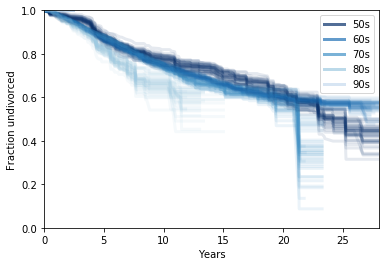

In [44]:
# Read and clean cycle 6 data
resp6 = survival.ReadFemResp2002()
CleanData(resp6)
married6 = resp6[resp6.evrmarry==1]

# Read and clean cycle 7 data
resp7 = survival.ReadFemResp2010()
CleanData(resp7)
married7 = resp7[resp7.evrmarry==1]

# Using resampling weights and plotting for various resamples.
ResampleDivorceCurveByDecade([married6, married7])